### <span style="color:#9393FF">Domestic Studies
</span> 


### **Part 1: Introduction**

We investigate the relationship between grain yield per hectare (kg/ha) and temperature conditions in Northeast China, focusing on the three provinces of Heilongjiang, Jilin, and Liaoning. To represent effective temperature, we use the Growing Degree Days (GDD) index as a key explanatory variable. Using a cleaned panel dataset, we conducted an OLS regression with year fixed effects to examine this relationship, and supplemented our analysis with descriptive statistics and visualizations.

### **Part 2: Data Processing**
**2.1 Downloading Weather Data from NASA via API**

*<span style="font-size:20px">API Info:</span>*

*<span style="font-size:20px">Source: NASA POWER (https://power.larc.nasa.gov/)</span>*

*<span style="font-size:20px">Endpoint: https://power.larc.nasa.gov/api/temporal/daily/point </span>*

*<span style="font-size:20px">Parameters used: T2M_MAX, T2M_MIN</span>*


In [ ]:
import os
import requests
import time

cities = {"Harbin": {"lat": 45.75, "lon": 126.63},
    "Changchun": {"lat": 43.88, "lon": 125.35},
    "Shenyang": {"lat": 41.80, "lon": 123.43}}
start_year = 2005
end_year = 2023
output_dir = "nasa_power_gdd_raw"
os.makedirs(output_dir, exist_ok=True)
for city, info in cities.items():
    lat, lon = info["lat"], info["lon"]
    for year in range(start_year, end_year + 1):
        start = f"{year}0101"
        end = f"{year}1231"
        url = (
            f"https://power.larc.nasa.gov/api/temporal/daily/point?"
            f"parameters=T2M_MAX,T2M_MIN&community=AG&longitude={lon}&latitude={lat}"
            f"&start={start}&end={end}&format=CSV"
        )
        file_path = os.path.join(output_dir, f"{city}_{year}.csv")
        try:
            print(f"Downloading: {city} {year}")
            r = requests.get(url)
            if r.status_code == 200:
                with open(file_path, "w", encoding="utf-8") as f:
                    f.write(r.text)
            else:
                print(f"Failed: {city} {year} {r.status_code}")
            time.sleep(1)  # 防止API限速
        except Exception as e:
            print(f"Error downloading {city} {year}: {e}")

Downloading: Harbin 2005
Downloading: Harbin 2006
Downloading: Harbin 2007
Downloading: Harbin 2008
Downloading: Harbin 2009
Downloading: Harbin 2010
Downloading: Harbin 2011
Downloading: Harbin 2012
Downloading: Harbin 2013
Downloading: Harbin 2014
Downloading: Harbin 2015
Downloading: Harbin 2016
Downloading: Harbin 2017
Downloading: Harbin 2018
Downloading: Harbin 2019
Downloading: Harbin 2020
Downloading: Harbin 2021
Downloading: Harbin 2022
Downloading: Harbin 2023
Downloading: Changchun 2005
Downloading: Changchun 2006
Downloading: Changchun 2007
Downloading: Changchun 2008
Downloading: Changchun 2009
Downloading: Changchun 2010
Downloading: Changchun 2011
Downloading: Changchun 2012
Downloading: Changchun 2013
Downloading: Changchun 2014
Downloading: Changchun 2015
Downloading: Changchun 2016
Downloading: Changchun 2017
Downloading: Changchun 2018
Downloading: Changchun 2019
Downloading: Changchun 2020
Downloading: Changchun 2021
Downloading: Changchun 2022
Downloading: Changchu

**2.2 Downloading yield data from the NBS for the same cities and years**

The yield data was manually selected and downloaded from the National Bureau of Statistics (NBS) website. It includes annual major crop yield data for the three provinces in Northeast China. The data were cleaned and organized for subsequent analysis of the relationship between temperature and crop yield.

*<span style="font-size:20px">https://data.stats.gov.cn/easyquery.htm?cn=E0103</span>*

In [29]:
# The example of raw data files are as follows:
import pandas as pd
file_path = os.path.join("..","..","data","raw","domestic_study_data","Heilongjiang_yield_clean.csv")
df = pd.read_csv(file_path)
print(df.head(1))

                指标    2023年    2022年    2021年    2020年    2019年    2018年  \
0  粮食单位面积产量(公斤/公顷)  5282.62  5287.08  5406.89  5222.73  5232.92  5281.07   

     2017年    2016年    2015年    2014年    2013年    2012年    2011年    2010年  \
0  5235.41  5221.96  5332.03  5300.48  5196.92  4994.31  4841.89  4526.17   

     2009年    2008年    2007年    2006年    2005年  
0  3950.61  4032.81  3471.27  3651.53  3574.24  


**2.3 Caculating GDD (Dependent variables)**

In this case, we use a base temperature (T_base) of 10°C, which is common for 
temperate crops. GDD is an effective proxy for assessing how climate variability 
impacts crop development and yield, especially in empirical regression analysis. 

<span style="color:#9393FF">GDD = max(0, (T_max + T_min)/2 - T_base)
</span> 




In [ ]:
import os
import pandas as pd

# saving path
input_dir = "../../data/raw/domestic_study_data/nasa_power_gdd_raw"
output_file = "../../data/processed/domestic_study_data/annual_gdd_summary.csv"
T_BASE = 10  # base temperature
summary = []

# Gdd calculation
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        parts = filename.replace(".csv", "").split("_")
        city = parts[0]
        year = parts[1]

        path = os.path.join(input_dir, filename)
        try:
            df = pd.read_csv(path, skiprows=10)  # 跳过前10行metadata
            tmax = df["T2M_MAX"]
            tmin = df["T2M_MIN"]

            gdd = ((tmax + tmin) / 2 - T_BASE).clip(lower=0)
            total_gdd = gdd.sum()

            summary.append({
                "City": city,
                "Year": int(year),
                "Annual_GDD": round(total_gdd, 2)
            })

        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Save summary to CSV
summary_df = pd.DataFrame(summary)
summary_df.sort_values(["City", "Year"], inplace=True)
summary_df.to_csv(output_file, index=False)

**2.4 Merging yield data and GDD data**

In [11]:
import pandas as pd
import os

# Obtaining current script directory
script_dir = os.getcwd()
raw_dir = os.path.join(script_dir, "../../data/raw/domestic_study_data")
processed_dir = os.path.join(script_dir, "../../data/processed/domestic_study_data")

# reading data
heilongjiang = pd.read_csv(os.path.join(raw_dir, "Heilongjiang_yield_clean.csv"))
jilin = pd.read_csv(os.path.join(raw_dir, "Jilin_yield_clean.csv"))
liaoning = pd.read_csv(os.path.join(raw_dir, "Liaoning_yield_clean.csv"))
gdd = pd.read_csv(os.path.join(processed_dir, "annual_gdd_summary.csv"))

# adding province column
heilongjiang["province"] = "Heilongjiang"
jilin["province"] = "Jilin"
liaoning["province"] = "Liaoning"

# merging data
df = pd.concat([heilongjiang, jilin, liaoning], ignore_index=True)

# wide to long format
df_long = df.melt(id_vars=["指标", "province"], var_name="year", value_name="value")
df_long["year"] = df_long["year"].str.extract(r'(\d{4})')  # 提取年份字符串
df_long = df_long.dropna(subset=["year"])                 # 删除year列为NaN的行
df_long["year"] = df_long["year"].astype(int)             # 再转为整数

# matching city names to provinces
gdd["province"] = gdd["City"].map({
    "Harbin": "Heilongjiang",
    "Changchun": "Jilin",
    "Shenyang": "Liaoning"
})

# merge GDD
panel = pd.merge(df_long, gdd[["province", "Year", "Annual_GDD"]],
                 left_on=["province", "year"],
                 right_on=["province", "Year"],
                 how="left").drop(columns=["Year"])

# saving
output_path = os.path.join(script_dir, "../../data/processed/domestic_study_data/panel_yield_gdd.csv")
panel.to_csv(output_path, index=False)

### **Part 3: Descriptive Analysis Classified by Province**


In [ ]:
# Descriptive statistics
grouped_stats_en = (
    panel.groupby("province")[["value", "Annual_GDD"]]
    .describe()
    .round(2)
)

# Flatten the MultiIndex columns
grouped_stats_en.columns = ['_'.join(col).strip() for col in grouped_stats_en.columns.values]

# Rename columns to English
grouped_stats_en = grouped_stats_en.rename(columns={
    "value_count": "Yield_obs",
    "value_mean": "Yield_mean",
    "value_std": "Yield_std",
    "value_min": "Yield_min",
    "value_25%": "Yield_25pct",
    "value_50%": "Yield_median",
    "value_75%": "Yield_75pct",
    "value_max": "Yield_max",
    "Annual_GDD_count": "GDD_obs",
    "Annual_GDD_mean": "GDD_mean",
    "Annual_GDD_std": "GDD_std",
    "Annual_GDD_min": "GDD_min",
    "Annual_GDD_25%": "GDD_25pct",
    "Annual_GDD_50%": "GDD_median",
    "Annual_GDD_75%": "GDD_75pct",
    "Annual_GDD_max": "GDD_max",
})

# Print the result
print("\n=== Descriptive Statistics by Province ===")
print(grouped_stats_en)

# save descriptive statistics
output_path = os.path.join(os.getcwd(), "..", "data", "processed", "domestic_study_data", "descriptive_stats.csv")
grouped_stats_en.to_csv(output_path, index=True)


=== Descriptive Statistics by Province ===
              Yield_obs  Yield_mean  Yield_std  Yield_min  Yield_25pct  \
province                                                                 
Heilongjiang      333.0     9097.03   12771.78        0.0      2723.90   
Jilin             321.0     9731.51   13182.02        0.0      2545.51   
Liaoning          328.0    12199.54   18578.31        0.0      2751.70   

              Yield_median  Yield_75pct  Yield_max  GDD_obs  GDD_mean  \
province                                                                
Heilongjiang       4032.81      6109.75   58859.74    399.0   1424.71   
Jilin              4228.07      7349.06   60561.13    399.0   1495.81   
Liaoning           5025.22      6646.02   65852.12    399.0   1828.45   

              GDD_std  GDD_min  GDD_25pct  GDD_median  GDD_75pct  GDD_max  
province                                                                   
Heilongjiang    69.29  1296.19    1353.72     1449.71    1477.91  1

### **Part 4:  Regression and Visualization**

In [14]:
pip install statsmodels


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/var/folders/dv/_5x4w0t95xb1flj112ms384r0000gn/T/ipykernel_44936/3675077516.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0004***' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coef_table.loc['Annual_GDD', 'Coef.'] = add_stars(coef_table.loc['Annual_GDD'])


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.127   
Dependent Variable: log_yield        AIC:                -19.0604
Date:               2025-06-17 12:32 BIC:                21.8006 
No. Observations:   57               Log-Likelihood:     29.530  
Df Model:           19               F-statistic:        1.428   
Df Residuals:       37               Prob (F-statistic): 0.173   
R-squared:          0.423            Scale:              0.032004
-----------------------------------------------------------------
                   Coef.   Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Annual_GDD       0.0004***   0.0001  2.8675 0.0068  0.0001 0.0006
Intercept           7.9528   0.2205 36.0635 0.0000  7.5060 8.3996
C(year)[T.2006]    -0.0048   0.1467 -0.0325 0.9742 -0.3021 0.2925
C(year)[T.2007]    -0.1116   0.1486 -0.7512 0.4573 -0.4128 0.1895
C(year)[T.2008]     0.0391 

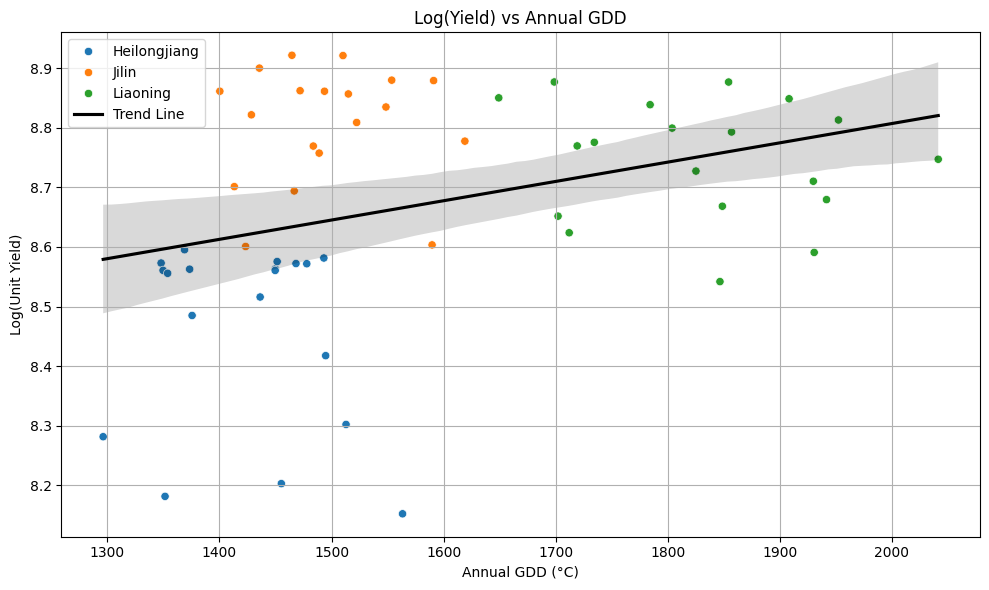

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import os

# construct relative path
data_path = os.path.join(script_dir, "../../data/processed/domestic_study_data/panel_yield_gdd.csv")
df = pd.read_csv(data_path)

# data cleaning
df = df[df["指标"] == "粮食单位面积产量(公斤/公顷)"]
df.head(2)
df = df.dropna(subset=["value", "Annual_GDD"])
df["log_yield"] = df["value"].apply(lambda x: np.log(x) if x > 0 else np.nan)
df = df.dropna(subset=["log_yield"])

# Log Regression model
model = smf.ols("log_yield ~ Annual_GDD + C(year)", data=df).fit()

# obtaining summary2 object
s = model.summary2()

# retrieving coef table
coef_table = s.tables[1]

# adding * to core variable
def add_stars(row):
    p = row['P>|t|']
    if p < 0.01:
        star = '***'
    elif p < 0.05:
        star = '**'
    elif p < 0.1:
        star = '*'
    else:
        star = ''
    return f"{row['Coef.']:.4f}{star}"
coef_table.loc['Annual_GDD', 'Coef.'] = add_stars(coef_table.loc['Annual_GDD'])

# reordering variables
ordered_vars = ['Annual_GDD'] + [v for v in coef_table.index if v != 'Annual_GDD']
s.tables[1] = coef_table.loc[ordered_vars]

# print
print(s)

# save regression summary
current_dir = os.getcwd()
save_path = os.path.join(current_dir, "regression_result.txt")
with open(save_path, "w", encoding="utf-8") as f:
    f.write(str(model.summary2()))
print(f"Regression result saved to: {save_path}")

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Annual_GDD", y="log_yield", hue="province")
sns.regplot(data=df, x="Annual_GDD", y="log_yield", scatter=False, color="black", label="Trend Line")
plt.title("Log(Yield) vs Annual GDD")
plt.xlabel("Annual GDD (°C)")
plt.ylabel("Log(Unit Yield)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# saving the plot
plot_path = os.path.join(os.getcwd(), "..", "..", "figure", "Domestic_studies", "Domestic_Studies.png")
plt.savefig(plot_path, dpi=300) 
plt.show()


### **Part 5: Conclusion**

In this study, we explored the relationship between agricultural productivity and temperature conditions in Northeast China, using grain yield per hectare as the outcome variable and annual Growing Degree Days (GDD) as the key explanatory variable.

By combining meteorological data from NASA’s POWER database with provincial crop yield data from the National Bureau of Statistics, we constructed a panel dataset covering the three major northeastern provinces—Heilongjiang, Jilin, and Liaoning—over the period 2005 to 2023.

Our regression results show that GDD has a positive and statistically significant effect on log-transformed grain yield, suggesting that within the observed temperature range, moderate increases in cumulative heat are associated with improved productivity. This finding is consistent with agronomic theory, as most temperate crops require a certain level of accumulated heat to mature and yield optimally.

However, the model's relatively low adjusted R-squared and the insignificance of many year fixed effects indicate that other factors—such as precipitation, soil quality, input usage, and crop varieties—may also play important roles and should be incorporated in future studies. Additionally, the linear specification does not capture possible threshold or non-linear effects of excessive heat, which may become more relevant under future climate scenarios.

Overall, our findings underscore the importance of tracking climate indicators like GDD in agricultural planning and adaptation strategies. Policymakers and farmers in Northeast China may benefit from timely temperature monitoring and crop-specific climate response assessments to enhance resilience in a changing climate.